In [1]:
import numpy as np
import time
import Levenshtein as lev
import os
from annchor.datasets import load_strings
from matplotlib import pyplot as plt



k=15

def levdist(a,b):
    return lev.distance(a,b)

strings_data = load_strings()
X = strings_data['X']
y = strings_data['y']
neighbor_graph = strings_data['neighbor_graph']

nx = X.shape[0]

for x in X[::100]:
    print(x[:50]+'...')

cuiojvfnseoksugfcbwzrcoxtjxrvojrguqttjpeauenefmkmv...
uiofnsosungdgrxiiprvojrgujfdttjioqunknefamhlkyihvx...
cxumzfltweskptzwnlgojkdxidrebonxcmxvbgxayoachwfcsy...
cmjpuuozflodwqvkascdyeosakdupdoeovnbgxpajotahpwaqc...
vzdiefjmblnumdjeetvbvhwgyasygrzhuckvpclnmtviobpzvy...
nziejmbmknuxdhjbgeyvwgasygrhcpdxcgnmtviubjvyzjemll...
yhdpczcjxirmebhfdueskkjjtbclvncxjrstxhqvtoyamaiyyb...
yfhwczcxakdtenvbfctugnkkkjbcvxcxjwfrgcstahaxyiooeb...
yoftbrcmmpngdfzrbyltahrfbtyowpdjrnqlnxncutdovbgabo...
tyoqbywjhdwzoufzrqyltahrefbdzyunpdypdynrmchutdvsbl...
dopgwqjiehqqhmprvhqmnlbpuwszjkjjbshqofaqeoejtcegjt...
rahobdixljmjfysmegdwyzyezulajkzloaxqnipgxhhbyoztzn...
dfgxsltkbpxvgqptghjnkaoofbwqqdnqlbbzjsqubtfwovkbsk...
pjwamicvegedmfetridbijgafupsgieffcwnmgmptjwnmwegvn...
ovitcihpokhyldkuvgahnqnmixsakzbmsipqympnxtucivgqyi...
xvepnposhktvmutozuhkbqarqsbxjrhxuumofmtyaaeesbeuhf...


In [10]:
from annchor import Annchor
from annchor import compare_neighbor_graphs


start_time = time.time()
ann = Annchor(X,
              levdist,
              n_anchors=23,
              n_neighbors=k,
              random_seed=5,
              n_samples=5000,
              p_work=0.12)

ann.fit()
print('ANNchor Time: %5.3f seconds' % (time.time()-start_time))


# Test accuracy
error = compare_neighbor_graphs(neighbor_graph,
                                ann.neighbor_graph,
                                k)
print('ANNchor Accuracy: %d incorrect NN pairs (%5.3f%%)' % (error,100*error/(k*nx)))

ANNchor Time: 37.104 seconds
ANNchor Accuracy: 11 incorrect NN pairs (0.046%)


In [11]:
# Extract the distance matrix
D = ann.to_sparse_matrix()

In [12]:
# Import UMAP and visualise the data
# Since we already have our distance matrix, this bit is quite easy!

from umap import UMAP
U = UMAP(metric='precomputed',n_neighbors=k-1)
T = U.fit_transform(D)
# T now holds the 2d UMAP projection of our data

/home/ec2-user/venv_annchor/lib64/python3.7/site-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


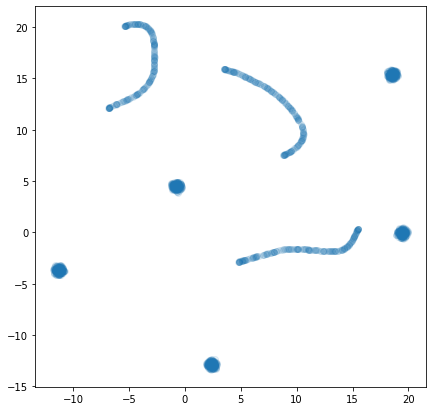

In [13]:
# View the 2D projection with matplotlib
fig,ax = plt.subplots(figsize=(7,7))
ax.scatter(*T.T,alpha=0.1)
plt.show()

In [14]:
# HDBSCAN Integration
#For this example, we'll convert to a dense matrix where not-computed distances are set to be 'large'.
#(We could keep with sparse matrices, but I want to sidestep a small technicality...)

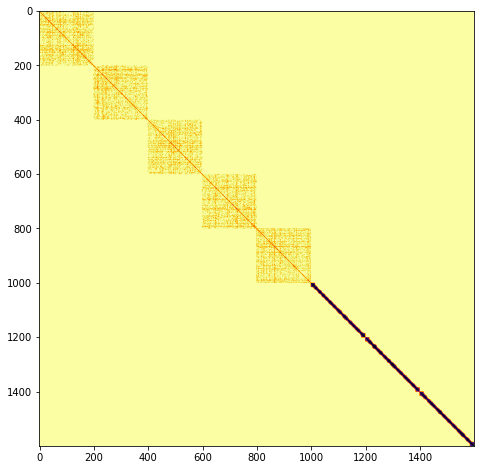

In [15]:
# Convert sparse distance matrix to dense distance matrix
dense = D.todense().astype(float)

# Set uncomputed distances to be twice the maximum distance
maxd = np.max(dense)
dense[dense==0]=2*maxd

# In the last step we made items far away from themselves, so we should undo this.
dense -= np.identity(len(X))*2*maxd

# Take a look at the distance matrix (we should immediately spot some structure!)
fig,ax = plt.subplots(figsize=(8,8))
ax.imshow(dense,cmap=plt.cm.inferno)
plt.show()

In [16]:
#import and run hdbscan clustering
from hdbscan import HDBSCAN
clusterer = HDBSCAN(metric='precomputed')
labels = clusterer.fit_predict(dense)
n_labels = len(set(labels).difference({-1}))
n_noise = np.sum(labels==-1)

#How many clusters do we find?
print('number of clusters = %d' % n_labels)

# How many points are 'noise'?
print('number of noise points = %d' % np.sum(labels==-1))

number of clusters = 8
number of noise points = 0


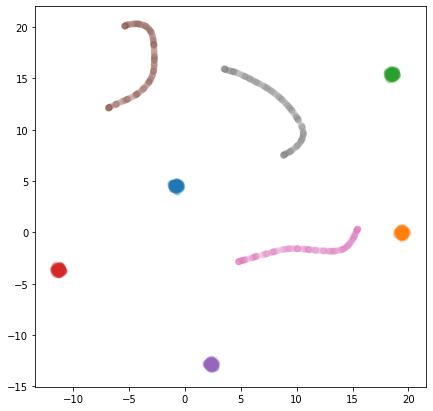

In [17]:
# Visualise the clusters using matplotlib

fig,ax = plt.subplots(figsize=(7,7))

# Plot noise (if present)
ax.scatter(*T[labels==-11].T,
           c='k',
           marker='.',
           alpha=0.1)

# Plot clusters
ax.scatter(*T[labels>-1].T,
           c=labels[labels>-1],
           cmap=plt.cm.tab10,
           vmin=0,
           vmax=10,
           marker='o',
           alpha=0.1)
plt.show()